# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 50
randamaug = True
bs = 1024
use_amp = True
lr = 1e-4

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import progress_bar

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

stty: 'standard input': Inappropriate ioctl for device


In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
train_df[train_df.fold==1].label.value_counts()

frog          1000
truck         1000
deer          1000
ship          1000
horse         1000
automobile    1000
dog           1000
cat           1000
airplane      1000
bird          1000
Name: label, dtype: int64

In [5]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [6]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=8, max_w_size=8, fill_value=0, p=0.5),
    albumentations.Rotate(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


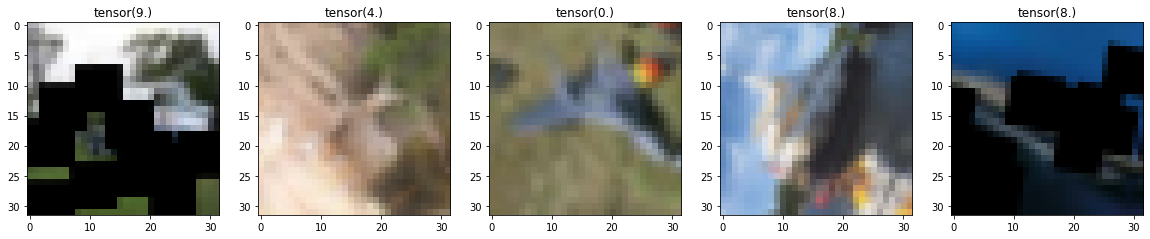

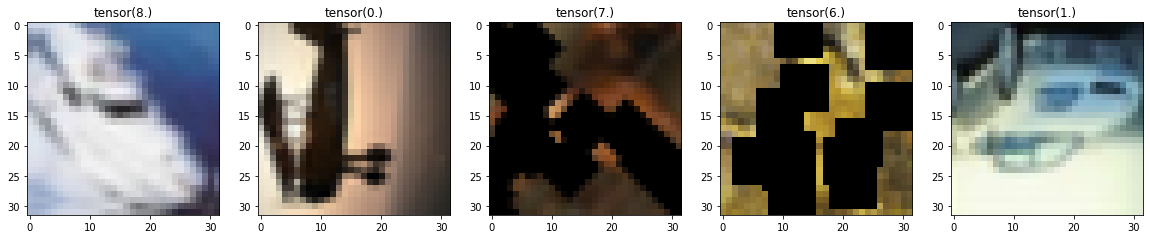

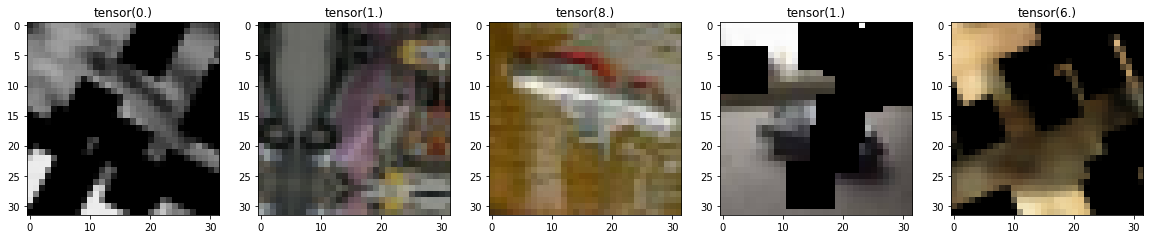

In [7]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [8]:
##### Training
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device).long()
        # Train with amp
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = net(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1)

##### Validation
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device).long()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Save checkpoint.
    acc = 100.*correct/total
    return test_loss/(batch_idx+1), acc

In [9]:
# Data
print('==> Preparing data..')
from randomaug import RandAugment
import torchvision
import torchvision.transforms as transforms

size = imsize
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Add RandAugment with N, M(hyperparameter)
if randamaug:
    N = 2; M = 7;
    transform_train.transforms.insert(0, RandAugment(N, M))

print('==> Preparing dataloader')
trainset = torchvision.datasets.CIFAR10(root='../vision-transformers-cifar10/data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='../vision-transformers-cifar10/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

==> Preparing data..
==> Preparing dataloader
Files already downloaded and verified
Files already downloaded and verified


In [10]:
from network.resnet import resnet20
net = resnet20(abits=8, wbits=8, pact=False, shallow=False)

abit/wbit: 8 8


In [11]:
net.forward(torch.randn(1,3,32,32))

tensor([[ 0.9163,  0.3955,  0.3443,  0.5644, -0.8719, -0.1131,  0.3995,  0.2713,
         -0.6865,  0.1081]], grad_fn=<AddmmBackward>)

# Train with quantization

from timm.scheduler import CosineLRScheduler

for shallow in [False]:
    for pact in [False,]:
        for k in range(3,9):
            net = resnet20(k,k,pact,shallow,True)

            net = net.cuda()
            mixup = False

            # Track experiment with wandb
            import wandb
            watermark = "resnet18_uniformquantize_k{}".format(k)
            if pact: watermark+="_pact"
            if shallow: 
                watermark+="_shallow"
            else:
                watermark+="_deep"
                
            # mess with wandb
            wandb.init(project="quantize_resnet2", name=watermark)

            # define loss function (criterion) and pptimizer
            criterion = nn.CrossEntropyLoss().cuda()

            # optimizer for pact
            optimizer = torch.optim.SGD(net.parameters(), lr=1e-3,
                                        momentum=0.9,
                                        weight_decay=0.0002)
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

            scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                                  warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

            best_prec1 = 0
            os.makedirs("models", exist_ok=True)

            for epoch in range(n_epochs):
                scheduler.step(epoch)
                # train for one epoch
                print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
                tloss = train(train_loader, model, criterion, optimizer, epoch)         

                # evaluate on validation set
                prec1, valloss = validate(val_loader, model, criterion)

                # wandb
                wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

                # remember best prec@1 and save checkpoint
                is_best = prec1 > best_prec1
                best_prec1 = max(prec1, best_prec1)

                print("Best prec1 : ", best_prec1)
                if is_best:
                    torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

In [ ]:
from timm.scheduler import CosineLRScheduler
from network.resnet2 import ResNet18
device = "cuda"


if NOQUANT_TRAIN:
    NOQUANT = True
else:
    NOQUANT = False

for shallow in [True, False]:
    for k in range(3,9):
        net = resnet20(k,k,False,shallow,NOQUANT)

        if shallow:
            checkpoint = torch.load('./models/resnet20_noquant_shallow.pth')
            net.load_state_dict(checkpoint)
        else:
            checkpoint = torch.load('./models/resnet20_noquant_deep.pth')
            net.load_state_dict(checkpoint)

        net = net.cuda()
        mixup = False

        # Track experiment with wandb
        import wandb
        watermark = "resnet20_quant_k{}".format(k)

        if shallow: 
            watermark+="_shallow"
        else:
            watermark+="_deep"

        # mess with wandb
        wandb.init(project="quantize_resnet2", name=watermark)

        # define loss function (criterion) and pptimizer
        criterion = nn.CrossEntropyLoss().cuda()

        # optimizer for pact
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-5, warmup_prefix=True)
        
        best_prec1 = 0
        os.makedirs("models", exist_ok=True)

        list_loss = []
        list_acc = []

        net.cuda()
        for epoch in range(n_epochs):
            start = time.time()
            trainloss = train(epoch)
            val_loss, prec1 = test(epoch)

            scheduler.step(epoch-1) # step cosine scheduling

            list_loss.append(val_loss)
            list_acc.append(prec1)

            # Log training..
            wandb.log({'epoch': epoch, 'train_loss': trainloss, 'val_loss': val_loss, "prec": prec1, "lr": optimizer.param_groups[0]["lr"],
            "epoch_time": time.time()-start})

            # remember best prec@1 and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)

            print("Best prec1 : ", best_prec1)
            if is_best:
                torch.save(net.state_dict(), os.path.join(f'models/{watermark}.pth'))

abit/wbit: 3 3


wandb: Currently logged in as: arutema47. Use `wandb login --relogin` to force relogin



Epoch: 0
 [===============================================================>.]  Step: 177ms | Tot: 9s906ms | Loss: 1.279 | Acc: 58.112% (29056/5000 49/49 ......................................................]  Step: 200ms | Tot: 1s250ms | Loss: 1.337 | Acc: 55.901% (4007/716 7/49 
 [================================================================>]  Step: 15ms | Tot: 1s543ms | Loss: 0.619 | Acc: 80.170% (8017/1000 100/100 ==========================>.................................]  Step: 14ms | Tot: 755ms | Loss: 0.617 | Acc: 80.560% (4028/500 50/100 ==================================>..............................]  Step: 13ms | Tot: 841ms | Loss: 0.616 | Acc: 80.556% (4350/540 54/100 
Best prec1 :  80.17

Epoch: 1
 [===============================================================>.]  Step: 176ms | Tot: 9s925ms | Loss: 1.337 | Acc: 56.884% (28442/5000 49/49 
 [================================================================>]  Step: 12ms | Tot: 1s561ms | Loss: 0.835 | Acc: 74.260% (

 [===============================================================>.]  Step: 175ms | Tot: 9s996ms | Loss: 0.971 | Acc: 65.822% (32911/5000 49/49 ===>.........................................................]  Step: 201ms | Tot: 1s248ms | Loss: 0.973 | Acc: 65.611% (4703/716 7/49 
 [================================================================>]  Step: 13ms | Tot: 1s609ms | Loss: 0.497 | Acc: 83.540% (8354/1000 100/100 0 45/10 46/100 47/100 =============================>.............................]  Step: 13ms | Tot: 940ms | Loss: 0.496 | Acc: 83.929% (4700/560 56/100 ============>...........................]  Step: 14ms | Tot: 982ms | Loss: 0.502 | Acc: 83.695% (4938/590 59/100 71/100 ============================================>..................]  Step: 13ms | Tot: 1s182ms | Loss: 0.501 | Acc: 83.694% (6026/720 72/100 
Best prec1 :  83.54

Epoch: 13
 [===============================================================>.]  Step: 180ms | Tot: 9s928ms | Loss: 0.963 | Acc: 66.134% (33067